In [1]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from umap import UMAP
import matplotlib.pyplot as plt
from clustering import *
from hdbscan import HDBSCAN
import joblib
from ipywidgets import interact, IntSlider, Dropdown
from functools import partial
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [2]:
data_small = "data/small_df/cleaned_small.csv"
data_avg = "data/average_df/cleaned_avg.csv"
data_tot = "data/total_df/cleaned_tot.csv"

df = pd.read_csv(data_tot)

corpus = df["cleaned_corpus"].tolist()
custom_stopwords = {
    "shaft", "plate", "member", "frame", "lever", "arm", "bar",
    "valve", "spring", "wheel", "machine", "rod", "pipe",
    "cylinder", "tube", "casing", "chamber", "head", "body"
}

corpus_cleaned = [delete_stopwords(text, custom_stopwords) for text in corpus]

https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html#umap

#### **EMBEDDING MODELS**

BERTopic starts with transforming our input documents into numerical representations. Although there are many ways this can be achieved, we typically use sentence-transformers ("all-MiniLM-L6-v2") as it is quite capable of capturing the semantic similarity between documents.

https://huggingface.co/spaces/mteb/leaderboard
FOR BEST EMBEDDING MODELS AS OF NOW

In [78]:
embedding_model_allenai = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_allenai = embedding_model_allenai.encode(corpus_cleaned)

joblib.dump(embeddings_allenai, 'embeddings_MiniLM.joblib')

['embeddings_MiniLM.joblib']

#### **DIMENSIONALITY REDUCTION**

An important aspect of BERTopic is the dimensionality reduction of the input embeddings. As embeddings are often high in dimensionality, clustering becomes difficult due to the curse of dimensionality.

A solution is to reduce the dimensionality of the embeddings to a workable dimensional space (e.g., 5) for clustering algorithms to work with. UMAP is used as a default in BERTopic since it can capture both the local and global high-dimensional space in lower dimensions.


##### UMAP

As a default, BERTopic uses UMAP to perform its dimensionality reduction. To use a UMAP model with custom parameters, we simply define it and pass it to BERTopic:

In [3]:
# Load the embeddings 
embeddings_allenai = joblib.load('embeddings_MiniLM.joblib')

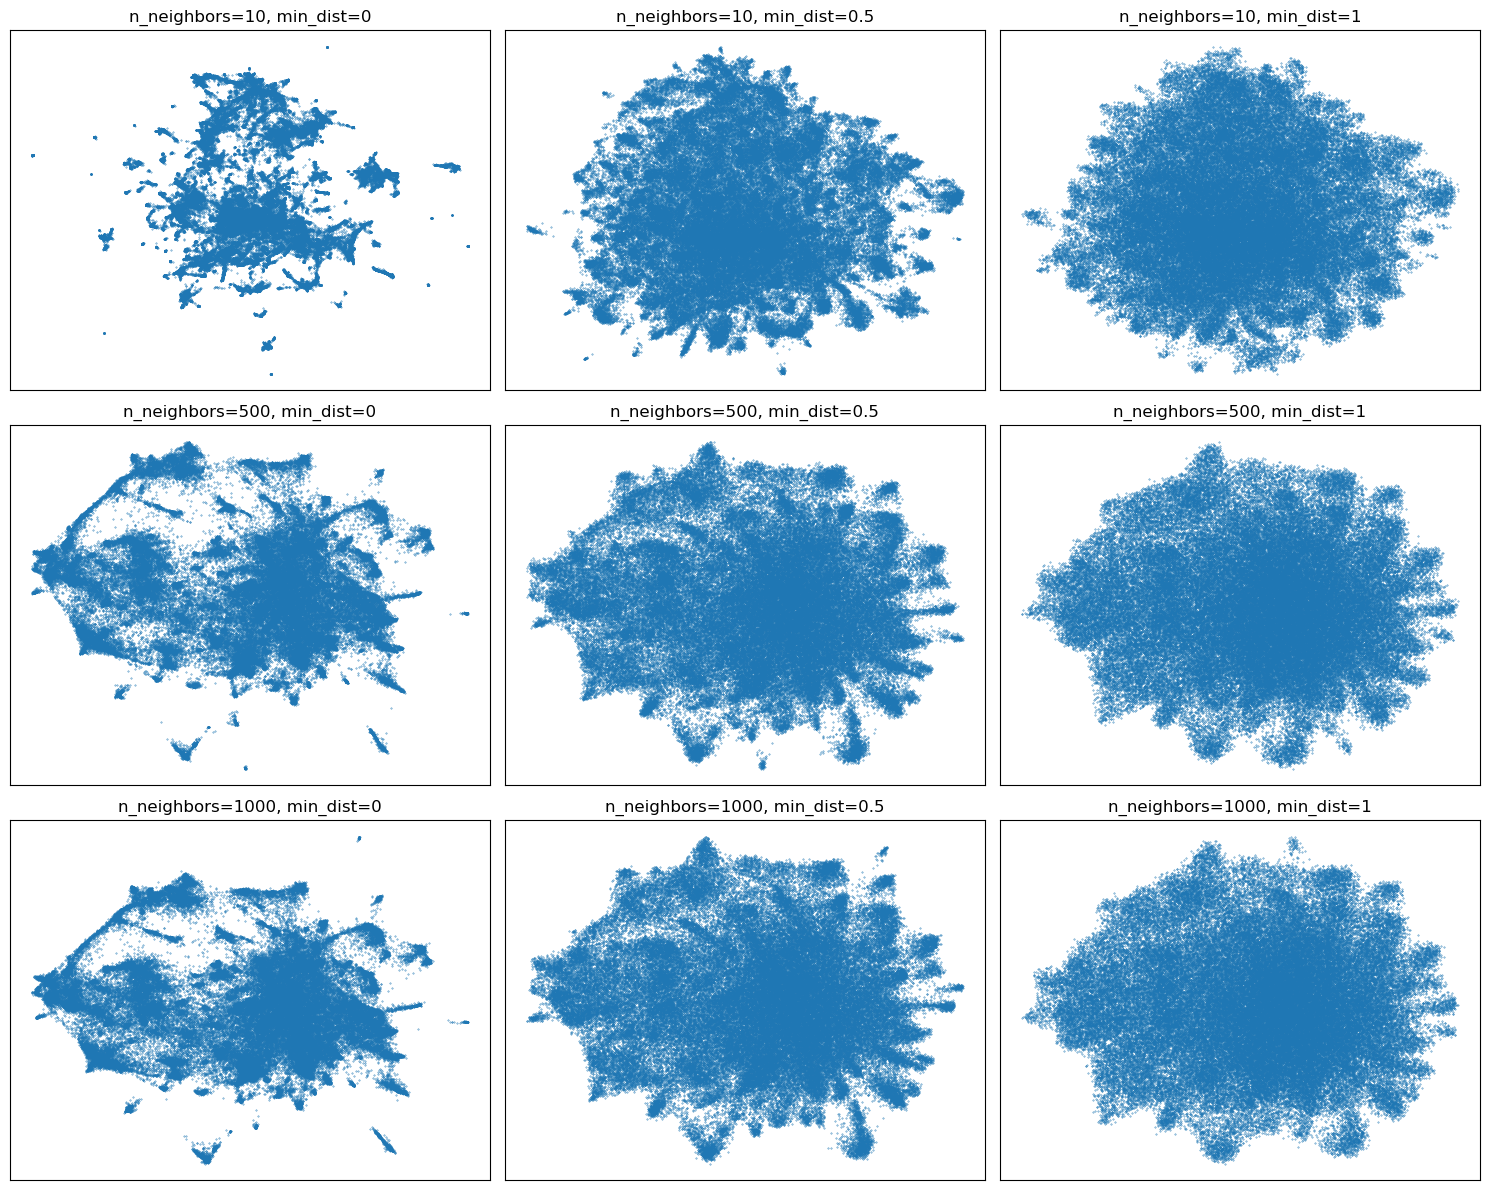

In [4]:
n_neighbors_list = [10, 500, 1000]
min_dist_list = [0, 0.5, 1]

umap_embeddings_dict = {}
umap_models_dict = {}

fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 12))

for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        ax = axes[i, j]
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                            n_components=2, random_state=42)
        X_umap = reducer.fit_transform(embeddings_allenai)

        umap_embeddings_dict[(n_neighbors, min_dist)] = X_umap
        umap_models_dict[(n_neighbors, min_dist)] = reducer

        sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=0.1, cmap='Spectral')
        ax.set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

In my opinion, there are two combinations which seem pretty good : (500,0) and (10, 0)

['X_umap_10_0.joblib']

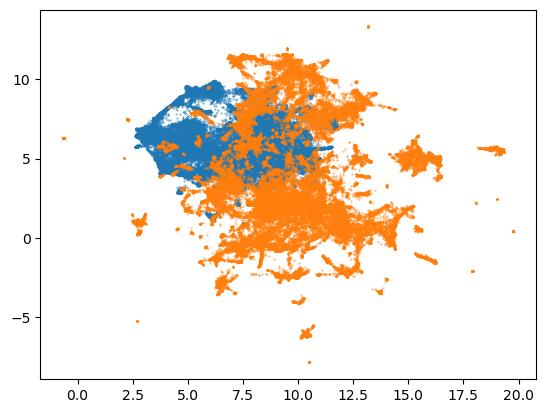

In [ ]:
umap_model_500 = umap_models_dict[(500, 0)]
X_umap_500 = umap_embeddings_dict[(500, 0)]

joblib.dump(umap_model_500, 'umap_model_500_0.joblib')
joblib.dump(X_umap_500, 'X_umap_500_0.joblib')

#### **CLUSTERING**

After reducing the dimensionality of our input embeddings, we need to cluster them into groups of similar embeddings to extract our topics. This process of clustering is quite important because the more performant our clustering technique the more accurate our topic representations are.

In BERTopic, we typically use HDBSCAN as it is quite capable of capturing structures with different densities.

##### HDBSCAN

As a default, BERTopic uses HDBSCAN to perform its clustering. To use a HDBSCAN model with custom parameters, we simply define it and pass it to BERTopic:

In [4]:
# Load the UMAP coordinates and model 
umap_model = joblib.load('umap_model_500_0.joblib')
X_umap = joblib.load('X_umap_500_0.joblib')

In [5]:
color_map = plt.get_cmap('tab20').colors + plt.get_cmap('tab10').colors
color_map += plt.get_cmap('Set3').colors
color_map = [f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' for r, g, b in color_map]
color_map = color_map[:100]

def compute_hdbscan(min_cluster_sizes, min_samples_list, X_umap):
    hdbscan_labels_dict = {}
    hdbscan_models_dict = {}

    for i, min_cluster_size in enumerate(min_cluster_sizes):
        for j, min_samples in enumerate(min_samples_list):
            clusterer = HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples)
            labels = clusterer.fit_predict(X_umap)

            hdbscan_labels_dict[(min_cluster_size, min_samples)] = labels
            hdbscan_models_dict[(min_cluster_size, min_samples)] = clusterer
    return hdbscan_labels_dict, hdbscan_models_dict

def plot_hdbscan(labels_dict, min_cluster_size, min_samples):
    labels = labels_dict[(min_cluster_size, min_samples)]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=0.5)
    plt.title(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}")
    plt.xticks([])
    plt.yticks([])
    plt.show()


##### BIG MODELS

In [6]:
# clusters with big parameters
min_cluster_sizes_big = [500, 750, 1000]
min_samples_list_big = [500, 750, 1000]

hdbscan_labels_dict_big, hdbscan_models_dict_big = compute_hdbscan(min_cluster_sizes_big, min_samples_list_big, X_umap)

# clusters with small parameters
min_cluster_sizes_small = [10, 200, 400]
min_samples_list_small = [10, 200, 400]

hdbscan_labels_dict_small, hdbscan_models_dict_small = compute_hdbscan(min_cluster_sizes_small, min_samples_list_small, X_umap)

In [7]:
demo_min_cluster = [10, 500, 1000]
demo_min_samples = [10, 500, 1000]
hdbscan_labels_dict_demo, hdbscan_models_dict_demo = compute_hdbscan(demo_min_cluster, demo_min_samples, X_umap)

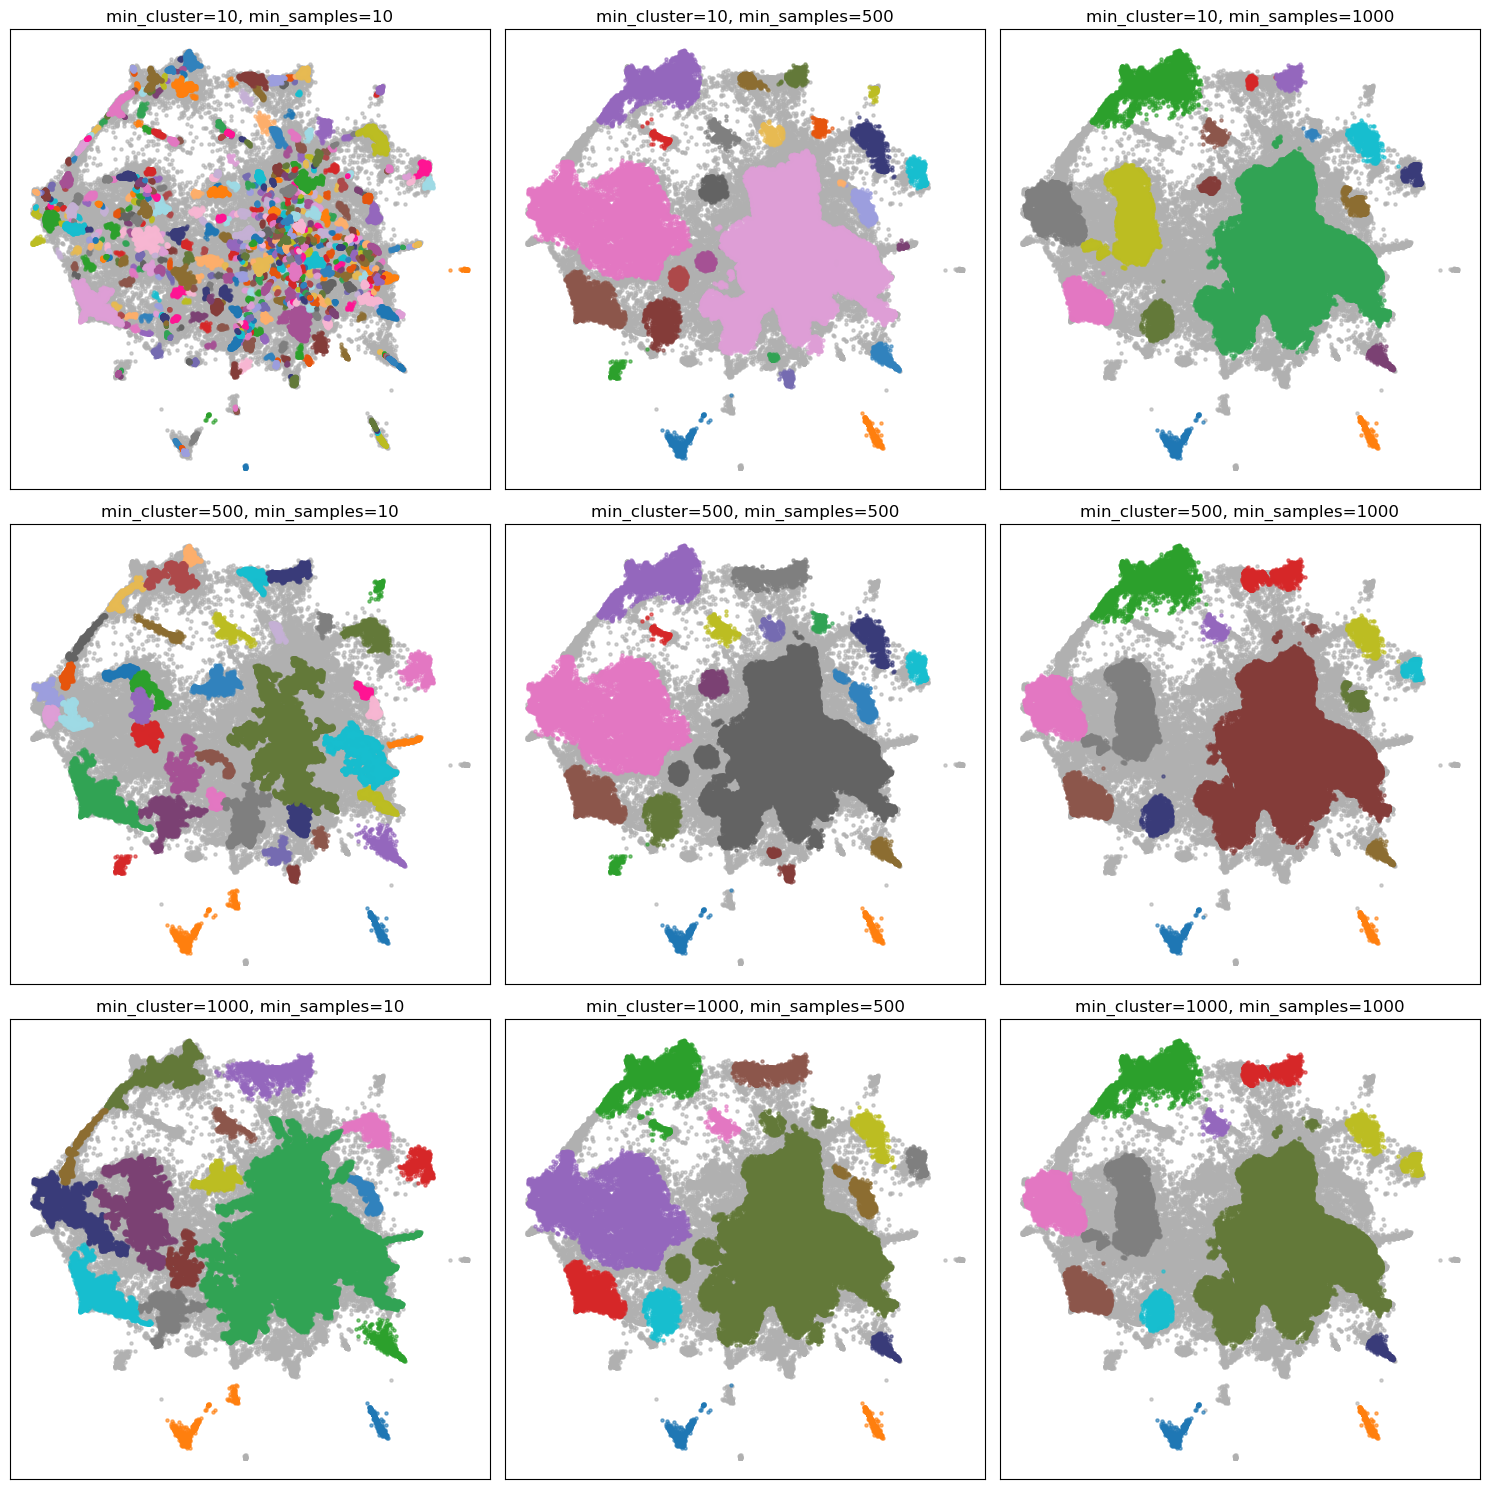

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

distinct_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173",
    "#3182bd", "#31a354", "#756bb1", "#636363", "#e6550d",
    "#9c9ede", "#fdae6b", "#e7ba52", "#ad494a", "#a55194",
    "#de9ed6", "#9edae5", "#ff1493", "#f7b6d2", "#c5b0d5"
]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

plot_idx = 0
for min_cluster_size in demo_min_cluster:
    for min_samples in demo_min_samples:
        ax = axes[plot_idx]
        labels = hdbscan_labels_dict_demo[(min_cluster_size, min_samples)]

        unique_labels = np.unique(labels)
        for label in unique_labels:
            color = "#B0B0B0" if label == -1 else distinct_colors[label % len(distinct_colors)]
            mask = labels == label
            ax.scatter(X_umap[mask, 0], X_umap[mask, 1], s=5, c=color, alpha=0.6)

        ax.set_title(f"min_cluster={min_cluster_size}, min_samples={min_samples}")
        ax.set_xticks([])
        ax.set_yticks([])
        plot_idx += 1

plt.tight_layout()
plt.show()

In [ ]:
from ipywidgets import VBox, HBox, Layout, Checkbox, Output, Label
from IPython.display import display, clear_output
import ipywidgets as widgets

suppress_observers = False

def plot_hdbscan_interactive(labels_dict, min_cluster_size, min_samples):
    labels = labels_dict[(min_cluster_size, min_samples)]
    total_points = len(labels)
    
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    n_noise = cluster_counts.get(-1, 0)
    noise_pct = (n_noise / total_points) * 100
    n_clusters = len([k for k in unique if k != -1])
    
    label_color_map = {}
    next_color = 0
    for label in sorted(unique):
        if label == -1:
            label_color_map[label] = 'lightgrey'
        else:
            label_color_map[label] = color_map[next_color % len(color_map)]
            next_color += 1
    colors = [label_color_map[label] for label in labels]

    fig = make_subplots(rows=1, cols=2, subplot_titles=(
        f"UMAP + HDBSCAN (clusters={n_clusters})",
        "Cluster Size Distribution"
    ))

    hover_text = [f"Cluster: {label}" for label in labels]
    scatter = go.Scattergl(
        x=X_umap[:, 0], y=X_umap[:, 1],
        mode='markers',
        marker=dict(color=colors, size=3),
        text=hover_text,
        hoverinfo='text'
    )
    fig.add_trace(scatter, row=1, col=1)

    bar_labels = [label for label in unique if label != -1]
    bar_counts = [cluster_counts[label] for label in bar_labels]
    bar_colors = [label_color_map[label] for label in bar_labels]
    bar = go.Bar(x=[str(label) for label in bar_labels], y=bar_counts, marker_color=bar_colors)
    fig.add_trace(bar, row=1, col=2)

    fig.add_annotation(
        text=f"Noise (unlabeled) points: {n_noise} ({noise_pct:.1f}%)",
        xref="paper", yref="paper",
        x=0.5, y=1.2, showarrow=False,
        font=dict(size=14)
    )

    fig.update_layout(height=500, width=900, showlegend=False)
    fig.update_xaxes(title_text="UMAP-1", row=1, col=1)
    fig.update_yaxes(title_text="UMAP-2", row=1, col=1)
    fig.update_xaxes(title_text="Cluster Label", row=1, col=2)
    fig.update_yaxes(title_text="Size", row=1, col=2)
    fig.show()

plot_output = Output()

scale_small = Checkbox(value=True, description="small")
scale_big = Checkbox(value=False, description="big")

def get_scale():
    return "small" if scale_small.value else "big"

def enforce_single_check(change):
    if change['name'] == 'value' and change['type'] == 'change':
        if change['owner'] == scale_small and change['new']:
            scale_big.value = False
        elif change['owner'] == scale_big and change['new']:
            scale_small.value = False
        update_plot()

min_cluster_selector = Dropdown(
    options=min_cluster_sizes_small,
    value=min_cluster_sizes_small[0],  
    layout=Layout(width="150px")
)

min_samples_selector = Dropdown(
    options=min_samples_list_small,
    value=min_samples_list_small[0],
    layout=Layout(width="150px")
)

def dropdown_change_handler(change):
    if not suppress_observers and change['name'] == 'value':
        update_plot()

def get_selected_values():
    return min_cluster_selector.value, min_samples_selector.value

def update_plot():
    global suppress_observers
    suppress_observers = True
    scale = get_scale()
    min_cluster_size, min_samples = get_selected_values()

    if scale == "small":
        min_cluster_selector.options = min_cluster_sizes_small
        min_samples_selector.options = min_samples_list_small
        labels_dict = hdbscan_labels_dict_small
    else:
        min_cluster_selector.options = min_cluster_sizes_big
        min_samples_selector.options = min_samples_list_big
        labels_dict = hdbscan_labels_dict_big
    
    suppress_observers = False
    with plot_output:
        clear_output(wait=True)
        plot_hdbscan_interactive(labels_dict, min_cluster_size, min_samples)

min_cluster_selector.observe(dropdown_change_handler, names="value")
min_samples_selector.observe(dropdown_change_handler, names="value")
scale_small.observe(enforce_single_check)
scale_big.observe(enforce_single_check)

param_title = widgets.HTML("<div style='text-align:center; font-size:18px; font-weight:bold; margin-bottom:2px;'>Parameters' Size</div>")
scale_box = HBox([scale_small, scale_big],
                         layout=Layout(justify_content="center", gap="0px"))

cluster_box = VBox([
    widgets.HTML("<div style='margin-bottom:2px; font-size:15px;'>Min Cluster Size</div>"),
    min_cluster_selector
], layout=Layout(align_items="center"))

sample_box = VBox([
    widgets.HTML("<div style='margin-bottom:2px; font-size:15px;'>Min Samples</div>"),
    min_samples_selector
], layout=Layout(align_items="center"))

bottom_row = HBox([cluster_box, sample_box],
                          layout=Layout(justify_content="space-around", padding="5px 20px 0px 25px"))

spacer = widgets.Box(layout=Layout(height='0px'))
ui = VBox([
    param_title,
    scale_box,
    spacer,
    plot_output,
    spacer,
    bottom_row
], layout=Layout(width="100%"))

display(ui)
update_plot()

['#f25454', '#f25654', '#f25754', '#f25954', '#f25a54', '#f25c54', '#f25d54', '#f25f54', '#f26054', '#f26154', '#f26354', '#f26454', '#f26654', '#f26754', '#f26954', '#f26a54', '#f26c54', '#f26d54', '#f26f54', '#f27054', '#f27254', '#f27354', '#f27454', '#f27654', '#f27754', '#f27954', '#f27a54', '#f27c54', '#f27d54', '#f27f54', '#f28054', '#f28254', '#f28354', '#f28554', '#f28654', '#f28754', '#f28954', '#f28a54', '#f28c54', '#f28d54', '#f28f54', '#f29054', '#f29254', '#f29354', '#f29554', '#f29654', '#f29854', '#f29954', '#f29a54', '#f29c54', '#f29d54', '#f29f54', '#f2a054', '#f2a254', '#f2a354', '#f2a554', '#f2a654', '#f2a854', '#f2a954', '#f2ab54', '#f2ac54', '#f2ad54', '#f2af54', '#f2b054', '#f2b254', '#f2b354', '#f2b554', '#f2b654', '#f2b854', '#f2b954', '#f2bb54', '#f2bc54', '#f2be54', '#f2bf54', '#f2c154', '#f2c254', '#f2c354', '#f2c554', '#f2c654', '#f2c854', '#f2c954', '#f2cb54', '#f2cc54', '#f2ce54', '#f2cf54', '#f2d154', '#f2d254', '#f2d454', '#f2d554', '#f2d654', '#f2d854'

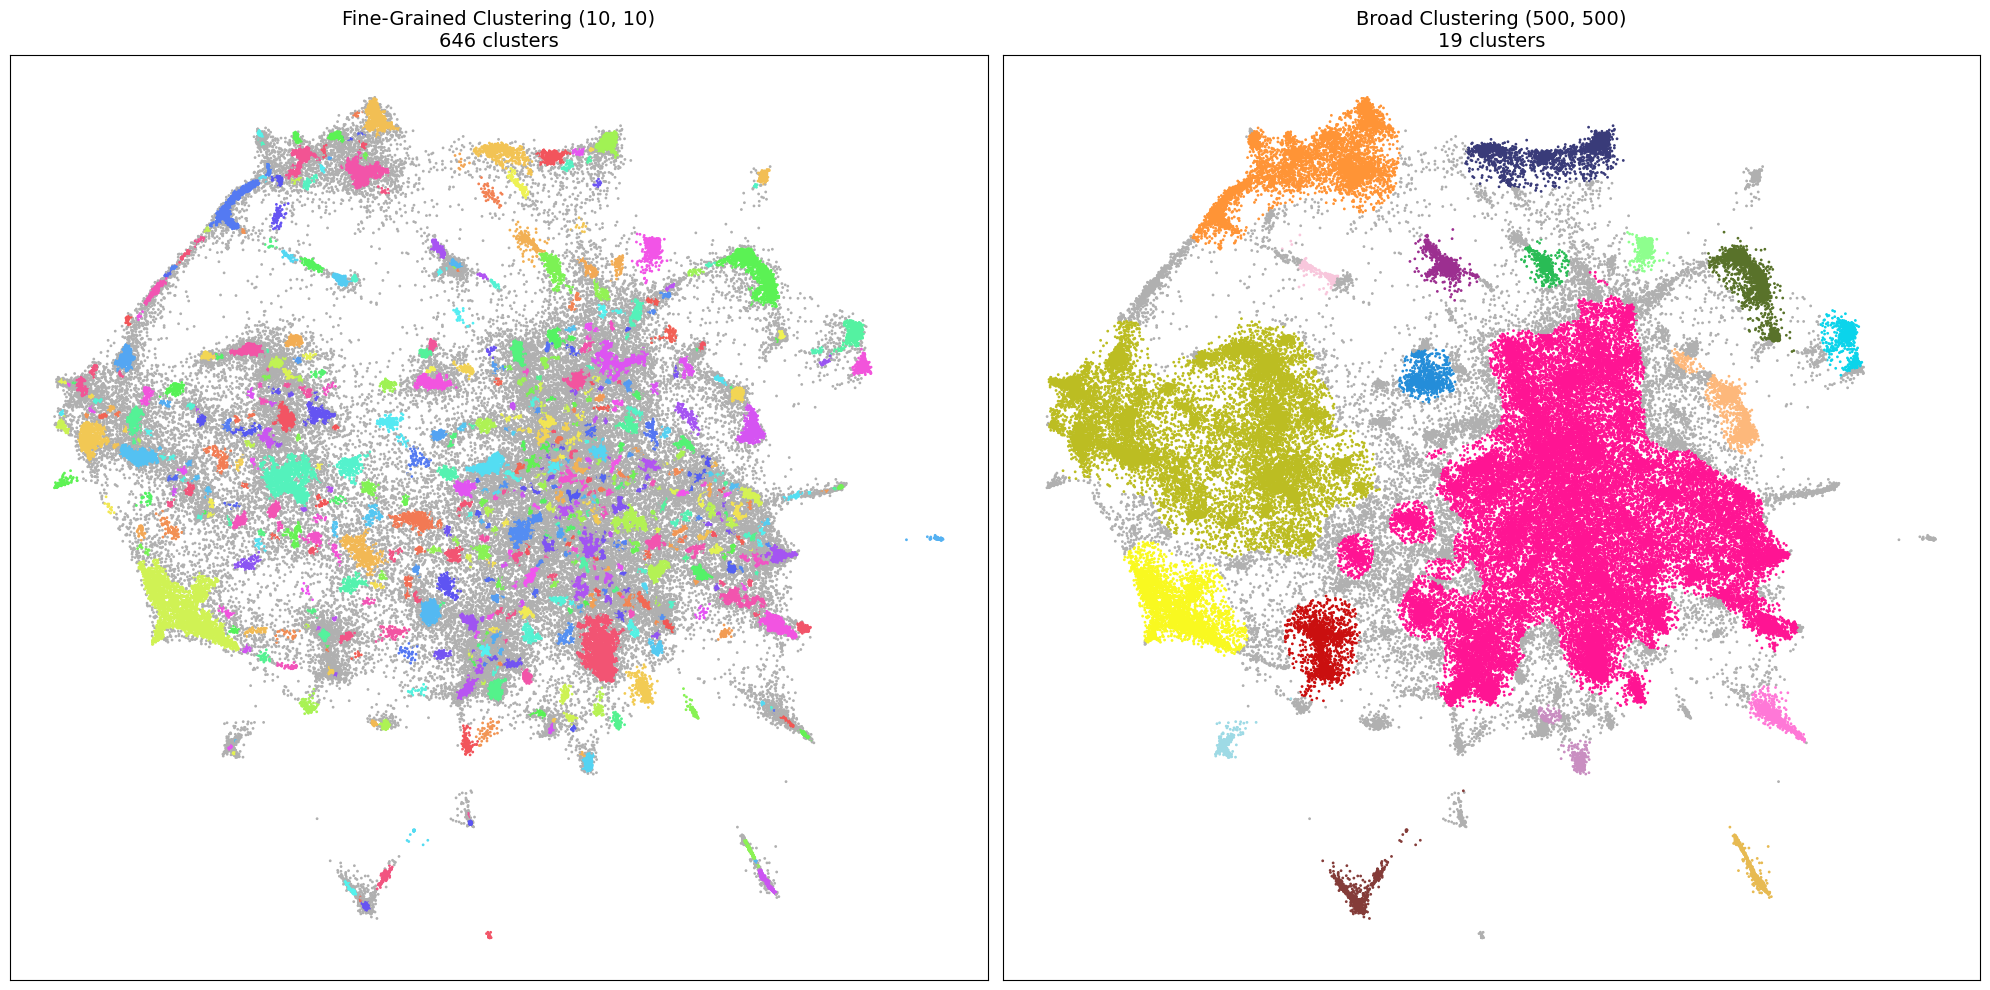

In [ ]:
import colorsys
COLOR_MAP = {
    0:  "#843c39",  # 0 : gun
    1:  "#e7ba52",  # 1 : tire, wheel
    2:  "#9edae5",  # 2 : bottle, stopper
    3:  "#f8c7dc",  # 3 : imaging devices
    4:  "#ff9436",  # 4 : electro magnetic
    5:  "#f9f920",  # 5 : chimie
    6:  "#bcbd22",  # 6 : valvle, chamber
    7:  "#393b79",  # 7 : rail, track
    8:  "#9c2f90",  # 8 : instrument, music 
    9:  "#0bd4eb",  # 9 : sash, window
    10: "#59722A",  # 10 : mold, plate
    11: "#ca0f0f",  # 11 : shoe, heel
    12: "#ff78d7",  # 12 : machine / motion
    13: "#c98ec1",  # 13 : machine / grinding
    14: "#248dd9",  # 14 : boat
    15: "#fdb87b",  # 15 : furniture
    16: "#8eff8e",  # 16 : car coupling
    17: "#29bc55",  # 17 : brake / suspension
    18: "#ff1493",  # 18 : MACHINE
}

def generate_646_colors():
    colors = []
    for i in range(646):
        hue = i / 646
        sat = 0.65
        val = 0.95
        r, g, b = colorsys.hsv_to_rgb(hue, sat, val)
        colors.append(f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}")
    return colors

FINE_COLORS = generate_646_colors()

def plot_two_hdbscan_visualizations(labels_1, labels_2, title_1, title_2):
    np.random.seed(42)
    noise_color = "#B0B0B0"

    def get_random_colors(labels):
        """ assign random color to each unique fine-grained cluster (excluding -1). """
        valid_labels = labels[labels != -1]
        unique_clusters = np.sort(np.unique(valid_labels))

        np.random.shuffle(FINE_COLORS)

        color_map = {
            cluster: FINE_COLORS[i % len(FINE_COLORS)]
            for i, cluster in enumerate(unique_clusters)
        }

        point_colors = np.array([
            color_map[label] if label != -1 else noise_color
            for label in labels
        ])
        return point_colors, len(unique_clusters)

    def get_color_map_colors(labels):
        """ COLOR_MAP for broader clusters; any cluster key not in COLOR_MAP
        will be assigned noise_color"""
        valid_labels = labels[labels != -1]
        unique_clusters = np.sort(np.unique(valid_labels))

        color_map = {
            cluster: COLOR_MAP.get(cluster, noise_color)
            for cluster in unique_clusters
        }
        point_colors = np.array([
            color_map[label] if label != -1 else noise_color
            for label in labels
        ])
        return point_colors, len(unique_clusters)

    colors_1, n_clusters_1 = get_random_colors(labels_1)
    colors_2, n_clusters_2 = get_color_map_colors(labels_2)

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    axes[0].scatter(X_umap[:, 0], X_umap[:, 1], c=colors_1, s=1)
    axes[0].set_title(f"{title_1}\n{n_clusters_1} clusters", fontsize=14)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=colors_2, s=1)
    axes[1].set_title(f"{title_2}\n{n_clusters_2} clusters", fontsize=14)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()

plot_two_hdbscan_visualizations(
    labels_1=hdbscan_labels_dict_small[(10, 10)],
    labels_2=hdbscan_labels_dict_big[(500, 500)],
    title_1="Fine-Grained Clustering (10, 10)",
    title_2="Broad Clustering (500, 500)"
)

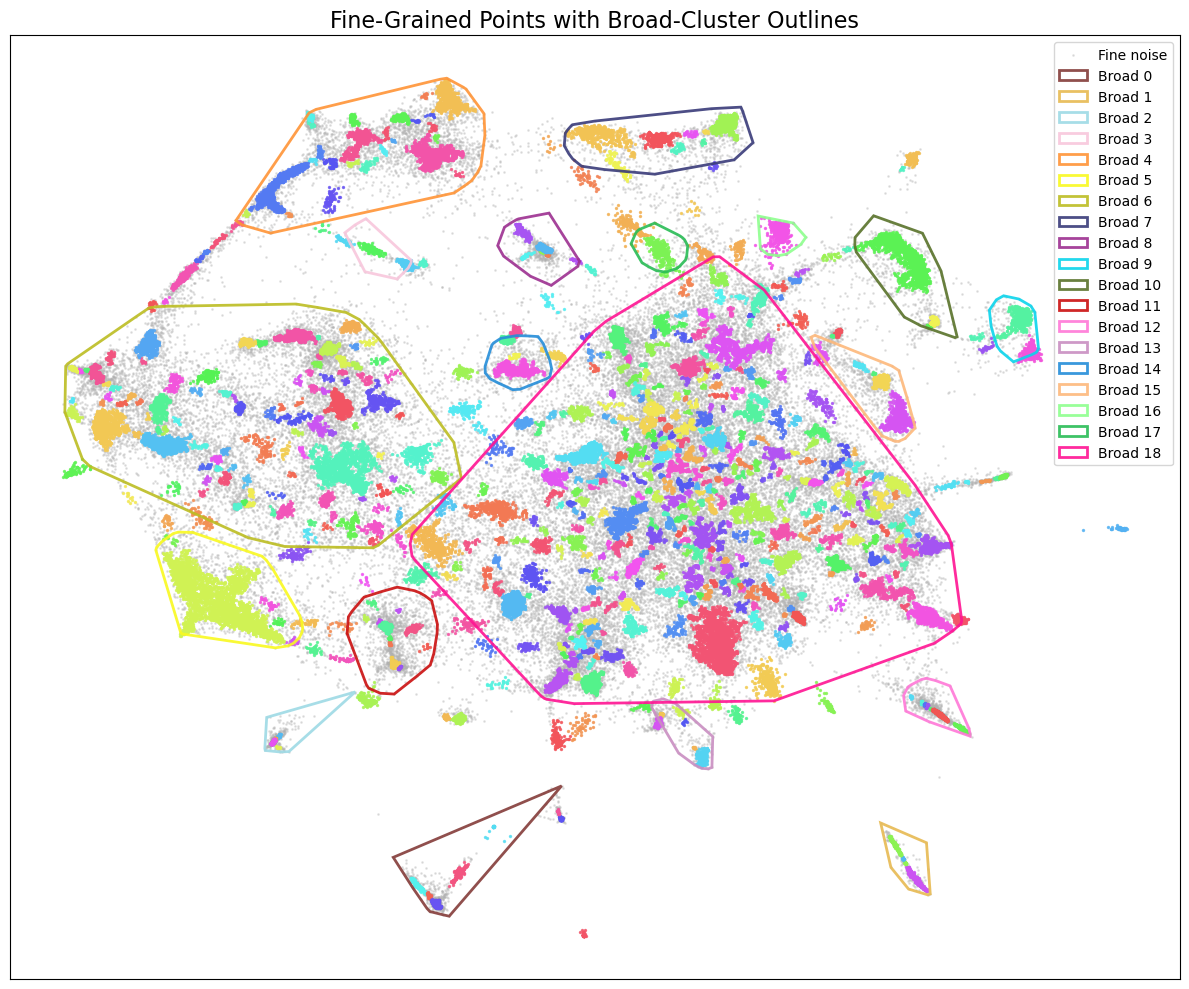

In [ ]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import colorsys

def plot_fine_with_broad_outlines(
    X_umap, 
    labels_fine, 
    labels_broad, 
    COLOR_MAP_broad=None, 
    noise_color_fine="#B0B0B0"
):
    """
    fine‐grained clustering points with convex‐hull outlines of broad clusters.
    """
    fig, ax = plt.subplots(figsize=(12,10))
    
    # build a color palette for fine‐grained clusters (random, or a fixed list).
    np.random.seed(0)
    unique_fine = np.unique(labels_fine[labels_fine != -1])
    fine_color_map = {c: FINE_COLORS[i] for i,c in enumerate(unique_fine)}
    
    mask_fine_noise = (labels_fine == -1)
    ax.scatter(
        X_umap[mask_fine_noise,0], 
        X_umap[mask_fine_noise,1], 
        s=1, 
        c=noise_color_fine, 
        label="Fine noise",
        alpha=0.3
    )
    
    for cluster_id in unique_fine:
        mask = (labels_fine == cluster_id)
        ax.scatter(
            X_umap[mask,0], 
            X_umap[mask,1], 
            s=2, 
            color=fine_color_map[cluster_id], 
            label=f"Fine {cluster_id}",
            alpha=0.8
        )
    
    unique_broad = np.unique(labels_broad[labels_broad != -1])
    
    if COLOR_MAP_broad is None:
        palette = plt.cm.tab20(np.linspace(0,1,len(unique_broad)))
        COLOR_MAP_broad = {c: palette[i] for i,c in enumerate(unique_broad)}
    
    for b in unique_broad:
        mask_b = (labels_broad == b)
        pts = X_umap[mask_b]
        if len(pts) < 3:
            continue
        
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices] 
        
        poly = Polygon(
            hull_pts,
            facecolor="none",
            edgecolor=COLOR_MAP_broad[b],
            lw=2,
            alpha=0.9,
            label=f"Broad {b}"
        )
        ax.add_patch(poly)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Fine‐Grained Points with Broad‐Cluster Outlines", fontsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    keep_handles = []
    keep_labels = []
    for h,lab in zip(handles, labels):
        if lab.startswith("Broad") or lab == "Fine noise":
            keep_handles.append(h)
            keep_labels.append(lab)
    ax.legend(handles=keep_handles, labels=keep_labels, loc="upper right", fontsize=10)
    
    plt.tight_layout()
    plt.show()

plot_fine_with_broad_outlines(X_umap, hdbscan_labels_dict_small[(10, 10)], hdbscan_labels_dict_big[(500, 500)], COLOR_MAP)

In [ ]:
labels_series = pd.Series(hdbscan_labels_dict_big[(500,500)])

cluster_counts = labels_series.value_counts().sort_index()

print("Number of patents in each cluster (including noise):")
print(cluster_counts)
total_patents = len(hdbscan_labels_dict_big[(500, 500)])
print(f"Total number of patents clustered (including noise): {total_patents}")

Number of patents in each cluster (including noise):
-1     15269
 0      1353
 1      1355
 2       762
 3       521
 4      5747
 5      3393
 6     16279
 7      2499
 8      1084
 9      1112
 10     2342
 11     1768
 12     1577
 13      626
 14      813
 15     1482
 16      756
 17      651
 18    40612
Name: count, dtype: int64
Total number of patents clustered (including noise): 100001


### C-TFIDF ON CLUSTERS

In [23]:
hdbscan_model_small = hdbscan_models_dict_small[(10,10)]
hdbscan_model_big = hdbscan_models_dict_big[(500,500)]

hdbscan_label_small = hdbscan_labels_dict_small[(10,10)]
hdbscan_label_big = hdbscan_labels_dict_big[(500,500)]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors

def top_words_per_topic(X, terms, top_n=10):
    words_per_topic = []
    for row in X:
        top_indices = row.toarray().flatten().argsort()[::-1][:top_n]
        top_words = [terms[i] for i in top_indices]
        words_per_topic.append(top_words)
    return words_per_topic

def top_words_per_patent(X_tfidf, index, vectorizer, top_n=10):
    row = X_tfidf[index]
    feature_names = np.array(vectorizer.get_feature_names_out())
    row_data = row.toarray().flatten()
    top_indices = row_data.argsort()[-top_n:][::-1]
    return feature_names[top_indices]

def get_topics(data, column):
    data = data[data[column] != -1]
    docs_per_topic = data.groupby(column)['cleaned_corpus'].apply(lambda x: ' '.join(x)).tolist()  
    
    vectorizer_tf_idf = TfidfVectorizer(stop_words="english", max_features=10000)
    X_tfidf = vectorizer_tf_idf.fit_transform(docs_per_topic)

    terms = vectorizer_tf_idf.get_feature_names_out()
    top_words = top_words_per_topic(X_tfidf, terms, top_n=10)

    dict_topic = {}
    for i, words in enumerate(top_words):
        dict_topic[i] = ", ".join(words)
    return dict_topic

def rank_patents_by_membership_strength(df, labels, probabilities, X_tfidf, vectorizer, topics_dict, subtopics_dict):
    copy = df.copy()
    copy["Cluster"] = labels
    copy["MembershipStrength"] = probabilities

    top_words_all = []
    cluster_top_words = []
    subcluster_topwords = []
    for idx in copy.index:
        top_words = top_words_per_patent(X_tfidf, idx, vectorizer)
        top_words_all.append(", ".join(top_words))
        cluster = copy.loc[idx, "Cluster"]
        if cluster == -1:
            cluster_top_words.append("")
        else:
            cluster_top_words.append(topics_dict.get(cluster, ""))
        subcluster = copy.loc[idx, "Sub-Cluster"]
        if subcluster == -1:
            subcluster_topwords.append("")
        else:
            subcluster_topwords.append(subtopics_dict.get(subcluster, ""))
    
    copy["TopWords"] = top_words_all
    copy["ClusterTopWords"] = cluster_top_words
    copy["SubClusterTopWords"] = subcluster_topwords

    return copy

def assign_closest_cluster(df, umap_coords):
    known = df[df["Cluster"] != -1]
    unknown = df[(df["Cluster"] == -1) & (df["Sub-Cluster"] != -1)]

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(umap_coords.loc[known.index])

    subcluster_centroids = (
        unknown.groupby("Sub-Cluster")[["umap_x", "umap_y"]]
        .mean()
    )
    distances, indices = neigh.kneighbors(subcluster_centroids)
    closest_clusters = df.iloc[known.index[indices.flatten()]]["Cluster"].values

    subcluster_to_closest = dict(zip(subcluster_centroids.index, closest_clusters))
    df["closest_cluster"] = df["Sub-Cluster"].map(subcluster_to_closest)

    return df

In [37]:
corpus = df["cleaned_corpus"].dropna().tolist()

custom_stopwords = {
    "shaft", "plate", "member", "frame", "lever", "arm", "bar",
    "valve", "spring", "wheel", "machine", "rod", "pipe",
    "cylinder", "tube", "casing", "chamber", "head", "body"
}

vectorizer_tf_idf = TfidfVectorizer(stop_words="english", max_features=10000)
X_tfidf = vectorizer_tf_idf.fit_transform(corpus_cleaned)

In [56]:
df_copy = df.copy()
df_copy["Cluster"] = hdbscan_label_big
df_copy["Sub-Cluster"] = hdbscan_label_small
df_copy["umap_x"] = X_umap[:, 0]
df_copy["umap_y"] = X_umap[:, 1]


topics_dict = get_topics(df_copy, "Cluster")
subtopics_dict = get_topics(df_copy, "Sub-Cluster")
ranked_by_strength_df = rank_patents_by_membership_strength(df_copy, hdbscan_label_big, hdbscan_model_big.probabilities_, X_tfidf, vectorizer_tf_idf, topics_dict, subtopics_dict)
ranked_by_strength_df = ranked_by_strength_df[["patent_id", "Cluster", "Sub-Cluster", "MembershipStrength", "TopWords", "ClusterTopWords", "SubClusterTopWords", "umap_x", "umap_y"]].sort_values(by=["Cluster", "Sub-Cluster", "MembershipStrength"], ascending=[True, True, False])

Topic 0: barrel, cartridge, gun, breech, spring, rear, projectile, forward, breechblock, lever
Topic 1: tire, rim, wheel, member, spoke, felly, hub, plate, spring, tread
Topic 2: bottle, neck, stopper, valve, cap, cork, liquid, machine, tube, member
Topic 3: lens, film, plate, camera, frame, spring, shutter, member, arm, mounted
Topic 4: circuit, contact, switch, current, armature, relay, wire, member, spring, magnet
Topic 5: process, acid, solution, material, water, metal, temperature, mixture, compound, chlorin
Topic 6: valve, pipe, chamber, cylinder, water, air, piston, casing, tube, pressure
Topic 7: rail, track, plate, switch, circuit, lever, contact, signal, tie, member
Topic 8: lever, arm, instrument, sound, record, member, key, valve, spring, shaft
Topic 9: sash, window, frame, member, plate, strip, bar, spring, screen, roller
Topic 10: door, bolt, lock, plate, member, spring, nut, key, lever, arm
Topic 11: mold, plate, wall, member, machine, block, frame, material, metal, shaf

In [ ]:
appartenance_series = (
    ranked_by_strength_df[ranked_by_strength_df["Sub-Cluster"] != -1]
    .groupby("Sub-Cluster")["Cluster"]
    .nunique()
    .rename("Appartenance")
)

# for each subcluster in cluster -1, compute and store the closest cluster. 
ranked_by_strength_df = assign_closest_cluster(ranked_by_strength_df, ranked_by_strength_df[["umap_x", "umap_y"]])  # replace with your actual UMAP cols
ranked_by_strength_df["Appartenance"] = ranked_by_strength_df["Sub-Cluster"].map(appartenance_series)
ranked_by_strength_df.to_csv("data/bert/topics_hdbscan.csv", index = False)

In [12]:
bert_results_file = "data/bert/topics_hdbscan.csv"
bert_results = pd.read_csv(bert_results_file)
bert_results.head()

patent_id  Cluster  Sub-Cluster  MembershipStrength   
0     613075       -1           -1                 0.0  \
1    1186073       -1           -1                 0.0   
2    1277032       -1           -1                 0.0   
3      75691       -1           -1                 0.0   
4    1196260       -1           -1                 0.0   

                                            TopWords ClusterTopWords   
0  vessel, gear, mast, rockshaft, gearing, gearwh...             NaN  \
1  semicircular, receptacle, compartment, rectang...             NaN   
2  crucible, refractory, lining, metal, ring, bri...             NaN   
3  stuff, bleaching, roll, rubber, merrill, vat, ...             NaN   
4  governor, elevator, brake, car, shoe, guide, b...             NaN   

  SubClusterTopWords    umap_x    umap_y  closest_cluster  Appartenance  
0                NaN  7.275265  6.913585              NaN           NaN  
1                NaN  9.343763  7.277885              NaN           NaN  
2                NaN  4.930326  4.584906              NaN           NaN  
3                NaN  6.704783  4.020303              NaN           NaN  
4                NaN  9.474376  7.838921              NaN           NaN

Patent Classification Summary
Unclassified by Cluster: 15269 patents (15.3%)
Unclassified by Sub-Cluster: 40572 patents (40.6%)
Both Cluster and Sub-Cluster == -1: 6945 patents (6.9%)
Cluster == -1 and Sub-Cluster != -1: 8324 patents (8.3%)
Cluster != -1 and Sub-Cluster == -1: 33627 patents (33.6%)
Sub-Clusters (Cluster == -1 & Sub-Cluster != -1 & Appartenance == 1): 86 unique sub-clusters


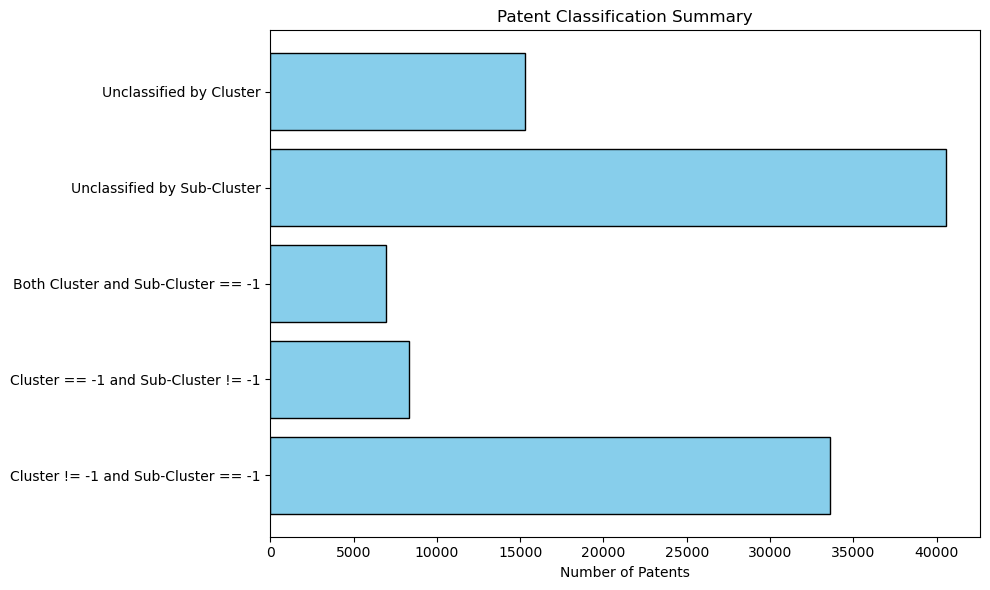

In [ ]:
total = len(ranked_by_strength_df)

results = {
    "Unclassified by Cluster": (ranked_by_strength_df["Cluster"] == -1).sum(),
    "Unclassified by Sub-Cluster": (ranked_by_strength_df["Sub-Cluster"] == -1).sum(),
    "Both Cluster and Sub-Cluster == -1": ((ranked_by_strength_df["Cluster"] == -1) & (ranked_by_strength_df["Sub-Cluster"] == -1)).sum(),
    "Cluster == -1 and Sub-Cluster != -1": ((ranked_by_strength_df["Cluster"] == -1) & (ranked_by_strength_df["Sub-Cluster"] != -1)).sum(),
    "Cluster != -1 and Sub-Cluster == -1": ((ranked_by_strength_df["Cluster"] != -1) & (ranked_by_strength_df["Sub-Cluster"] == -1)).sum(),
}

results["Sub-Clusters (Cluster == -1 & Sub-Cluster != -1 & Appartenance == 1)"] = ranked_by_strength_df[
    (ranked_by_strength_df["Cluster"] == -1) & (ranked_by_strength_df["Sub-Cluster"] != -1) & (ranked_by_strength_df["Appartenance"] == 1)
]["Sub-Cluster"].nunique()

print("Patent Classification Summary")
for k, v in results.items():
    if isinstance(v, tuple) or isinstance(v, list):
        count = v[0]
    else:
        count = v
    if "Sub-Clusters" not in k:
        percent = 100 * count / total
        print(f"{k}: {count} patents ({percent:.1f}%)")
    else:
        print(f"{k}: {count} unique sub-clusters")

labels = list(results.keys())[:-1]
counts = [results[k] for k in labels]

plt.figure(figsize=(10, 6))
plt.barh(labels, counts, color="skyblue", edgecolor="black")
plt.xlabel("Number of Patents")
plt.title("----------- Patent Classification Summary -----------")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
total = ranked_by_strength_df.copy()

membership_strength_df = (
    total
    .groupby(["Cluster", "Sub-Cluster"])["MembershipStrength"]
    .mean()
    .reset_index()
    .rename(columns={"MembershipStrength": "sub-clusterMembershipStrength"})
)

total_merged = pd.merge(
    total,
    membership_strength_df,
    on=["Cluster", "Sub-Cluster"],
    how="left"
)
total_merged.head()

patent_id  Cluster  Sub-Cluster  MembershipStrength   
0          613075       -1           -1                 0.0  \
1         1186073       -1           -1                 0.0   
2         1277032       -1           -1                 0.0   
3           75691       -1           -1                 0.0   
4         1196260       -1           -1                 0.0   
...           ...      ...          ...                 ...   
99996      153404       18          645                 1.0   
99997       67851       18          645                 1.0   
99998      194013       18          645                 1.0   
99999      405517       18          645                 1.0   
100000      68587       18          645                 1.0   

                                                 TopWords   
0       vessel, gear, mast, rockshaft, gearing, gearwh...  \
1       semicircular, receptacle, compartment, rectang...   
2       crucible, refractory, lining, metal, ring, bri...   
3       stuff, bleaching, roll, rubber, merrill, vat, ...   
4       governor, elevator, brake, car, shoe, guide, b...   
...                                                   ...   
99996   cultivator, beam, tongue, plow, axle, evener, ...   
99997   camplate, rake, raking, spindle, reel, platfor...   
99998   clearer, rakehead, teeth, rake, axle, seat, br...   
99999   hoop, staple, slot, stud, roll, diagonal, driv...   
100000  rake, pulley, hay, thimble, loading, endless, ...   

                                          ClusterTopWords   
0                                                          \
1                                                           
2                                                           
3                                                           
4                                                           
...                                                   ...   
99996   shaft, frame, member, arm, machine, lever, pla...   
99997   shaft, frame, member, arm, machine, lever, pla...   
99998   shaft, frame, member, arm, machine, lever, pla...   
99999   shaft, frame, member, arm, machine, lever, pla...   
100000  shaft, frame, member, arm, machine, lever, pla...   

                                       SubClusterTopWords   
0                                                          \
1                                                           
2                                                           
3                                                           
4                                                           
...                                                   ...   
99996   rake, shaft, rakehead, bar, frame, lever, arm,...   
99997   rake, shaft, rakehead, bar, frame, lever, arm,...   
99998   rake, shaft, rakehead, bar, frame, lever, arm,...   
99999   rake, shaft, rakehead, bar, frame, lever, arm,...   
100000  rake, shaft, rakehead, bar, frame, lever, arm,...   

        sub-clusterMembershipStrength  
0                                 0.0  
1                                 0.0  
2                                 0.0  
3                                 0.0  
4                                 0.0  
...                               ...  
99996                             1.0  
99997                             1.0  
99998                             1.0  
99999                             1.0  
100000                            1.0  

[100001 rows x 8 columns]

In [ ]:
interact_df = total_merged.copy()

interact_df["Count"] = interact_df.groupby(["Cluster", "Sub-Cluster"])["Sub-Cluster"].transform("count")

interact_df["ClusterTotal"] = interact_df.groupby("Cluster")["Sub-Cluster"].transform("count")
interact_df["Percentage"] = 100 * interact_df["Count"] / interact_df["ClusterTotal"]

interact_df["SubClusterTotal"] = interact_df.groupby("Sub-Cluster")["Sub-Cluster"].transform("count")
interact_df["SubClusterPercentage"] = 100 * interact_df["Count"] / interact_df["SubClusterTotal"]

cluster_dropdown = widgets.Dropdown(
    options=sorted(interact_df["Cluster"].unique()),
    description="Cluster:",
    layout=widgets.Layout(width="200px")
)

plot_output = widgets.Output()
def update_2_plot(cluster_id):
    with plot_output:
        clear_output(wait=True)
        
        cluster_df = interact_df[interact_df["Cluster"] == cluster_id]
        cluster_words = cluster_df["ClusterTopWords"].iloc[0]

        sub_df = (
            cluster_df.groupby(["Sub-Cluster", "SubClusterTopWords"], as_index=False)
            .agg({
                "Percentage": "first",
                "SubClusterPercentage": "first",
                "sub-clusterMembershipStrength": "mean"
            })
            .sort_values("Percentage", ascending=False)
        )

        fig = go.Figure()

        fig.add_trace(go.Bar(
            x=sub_df["Sub-Cluster"].astype(str),
            y=sub_df["Percentage"],
            text=sub_df["SubClusterTopWords"],
            customdata=np.stack([
                sub_df["sub-clusterMembershipStrength"].round(3)*100,
                sub_df["SubClusterPercentage"].round(2)
            ], axis=-1),
            hovertemplate=(
                "<b>Sub-Cluster %{x}</b><br>"
                "Percentage: %{y}<br>"
                "Top Words: %{text}<br>"
                "Avg Membership Strength: %{customdata[0]}%<br>"
                "Sub-Cluster Percentage: %{customdata[1]}%<extra></extra>"
            ),
            marker_color="steelblue"
        ))

        fig.update_layout(
            title=dict(
                text=f"Top Words for Cluster {cluster_id}: <b>{cluster_words}</b>",
                x=0.5,
                font=dict(size=16)
            ),
            xaxis_title="Sub-Cluster",
            yaxis_title="Number of Documents",
            height=450,
            margin=dict(t=80)
        )

        fig.show()

widgets.interact(update_2_plot, cluster_id=cluster_dropdown)

display(plot_output)
update_2_plot(cluster_dropdown.value)

interactive(children=(Dropdown(description='Cluster:', layout=Layout(width='200px'), options=(-1, 0, 1, 2, 3, …

Output()